In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap

In [2]:
def create_matrix(S, I, R, N):
    assert np.isclose(S + I + R, 1.0), "S + I + R should equal 1"

    total_population = N * N
    S_count = int(S * N**2)
    I_count = int(I * N**2)
    R_count = int(R * N**2)
    
    flat_array = np.zeros(int(N ** 2))
    flat_array[:S_count] = 0
    flat_array[S_count:S_count+I_count] = 1
    flat_array[S_count+I_count:] = 2

    np.random.shuffle(flat_array)

    matrix = flat_array.reshape(N, N)
    return matrix

In [3]:
matrix = create_matrix(0.99, 0.01, 0.0, 100)
print(matrix)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
# Set initial conditions and constants
S = 0.99
I = 0.01
R = 0.0
N = 1000
beta = 0.33
gamma = 0.14
t = 30

matrix = create_matrix(S, I, R, N)

Simulating step 1...
Simulating step 2...
Simulating step 3...
Simulating step 4...
Simulating step 5...
Simulating step 6...
Simulating step 7...
Simulating step 8...
Simulating step 9...
Simulating step 10...
Simulating step 11...
Simulating step 12...
Simulating step 13...
Simulating step 14...
Simulating step 15...
Simulating step 16...
Simulating step 17...
Simulating step 18...
Simulating step 19...
Simulating step 20...
Simulating step 21...
Simulating step 22...
Simulating step 23...
Simulating step 24...
Simulating step 25...
Simulating step 26...
Simulating step 27...
Simulating step 28...
Simulating step 29...
Simulation shape: (30, 1000, 1000)


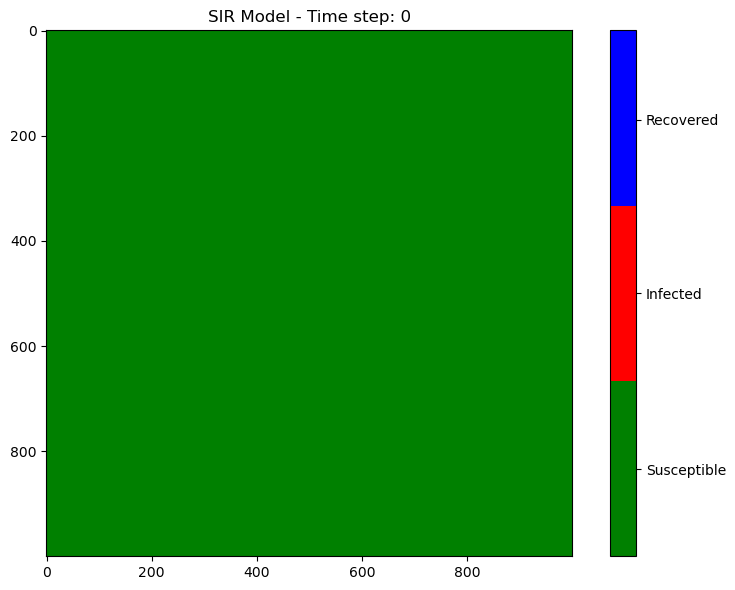

In [ ]:
def check_neighbors(matrix, i, j):
    rows, cols = matrix.shape
    neighbors = []
    
    for x in [i-1, i, i+1]:
        for y in [j-1, j, j+1]:
            if (x != i or y != j) and (0 <= x < rows) and (0 <= y < cols):
                neighbors.append((x, y))
    return neighbors

def SIR_simulate_step(matrix, beta, gamma, rng=np.random):
    rows, cols = matrix.shape
    new_matrix = matrix.copy()
    infection_targets = set()                    # use a set

    # infection phase
    infected_positions = np.argwhere(matrix == 1)  # all (i,j) where infected
    for i, j in infected_positions:
        for x, y in check_neighbors(matrix, i, j):
            if matrix[x, y] == 0 and rng.random() < beta:
                infection_targets.add((x, y))

    for x, y in infection_targets:
        new_matrix[x, y] = 1

    # recovery phase
    for i, j in infected_positions:              # reuse the list
        if rng.random() < gamma:
            new_matrix[i, j] = 2

    return new_matrix



def SIR_simulation(initial_matrix, beta, gamma, steps):
    simulations = [initial_matrix.copy()]
    current_matrix = initial_matrix.copy()
    
    for t in range(1, steps):
        print(f"Simulating step {t}...")
        current_matrix = SIR_simulate_step(current_matrix, beta, gamma)
        simulations.append(current_matrix.copy())
    return np.array(simulations)


def animate_SIR_simulation(simulation):
    print("Simulation shape:", simulation.shape)  # Should be (timesteps, rows, cols)
    
    # Define custom colormap for SIR states
    sir_colors = ['green', 'red', 'blue']  # S, I, R
    cmap = ListedColormap(sir_colors)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Create initial plot
    im = ax.imshow(simulation[0], cmap=cmap, vmin=0, vmax=2)
    
    # Add colorbar with state labels
    cbar = plt.colorbar(im, ticks=[0.33, 1.0, 1.66])
    cbar.ax.set_yticklabels(['Susceptible', 'Infected', 'Recovered'])
    
    # Set title
    ax.set_title('SIR Model Simulation')
    
    def update(t):
        """Update the plot for each frame."""
        im.set_data(simulation[t])
        ax.set_title(f'SIR Model - Time step: {t}')
        return [im]
    
    # Create animation
    timesteps = simulation.shape[0]
    ani = FuncAnimation(fig, update, frames=timesteps, interval=100, blit=True)
    
    plt.tight_layout()
    plt.show()
    
    return ani

simulations = SIR_simulation(matrix, beta, gamma, t)

ani = animate_SIR_simulation(simulations)
ani.save("sir_sim.gif", writer='pillow', fps=2)


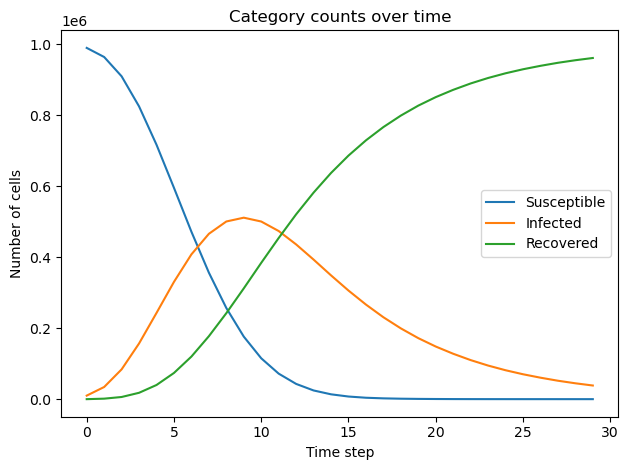

In [11]:
#sanity check for the spatial sim
# ----------- count categories over time ---------------
S_count = (simulations == 0).sum(axis=(1,2))
I_count = (simulations == 1).sum(axis=(1,2))
R_count = (simulations == 2).sum(axis=(1,2))

# ------------- plot time series -----------------------
plt.figure()
plt.plot(S_count, label="Susceptible")
plt.plot(I_count, label="Infected")
plt.plot(R_count, label="Recovered")
plt.xlabel("Time step")
plt.ylabel("Number of cells")
plt.title("Category counts over time")
plt.legend()
plt.tight_layout()
plt.show()

Speed up version test

Finished state 1
Finished state 2
Finished state 3
Finished state 4
{0: 227323, 1: 85, 2: 29, 3: 22563}


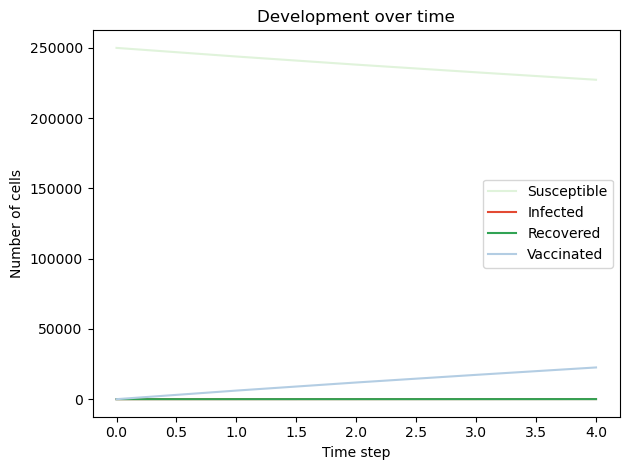

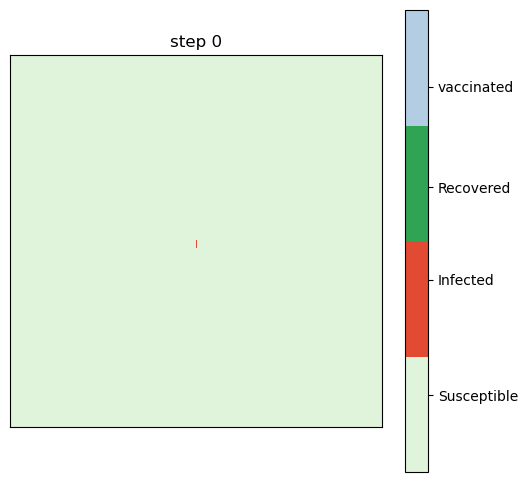

In [2]:
import numpy as np

"""Spatial S I R V B cellular‑automaton
State codes
0 : Susceptible (S)
1 : Infected    (I)
2 : Recovered   (R) – natural immunity
3 : Vaccinated  (V)

Model parameters (per step):
    beta_s   ‑ infection prob per S–I neighbour contact
    beta_v   ‑ breakthrough infection prob per V–I neighbour
    gamma    ‑ recovery prob for an infected cell
    v_rate   ‑ probability a given S gets vaccinated this step
    b_rate   ‑ fraction of *new* R or V that immediately lose immunity

The grid is updated synchronously: all events within a step use the state
at t, then updates are committed to t+1.
"""

# ------------------------------------------------------------
# 1. helper: list of valid Moore‑neighbour coordinates
# ------------------------------------------------------------

def neighbors(mat, i, j):
    rows, cols = mat.shape
    for x in (i-1, i, i+1):
        for y in (j-1, j, j+1):
            if (x, y) != (i, j) and 0 <= x < rows and 0 <= y < cols:
                yield x, y

# ------------------------------------------------------------
# 2. one lattice update (t -> t+1)
# ------------------------------------------------------------

def step_sirvb(grid, *, beta_s, beta_v, beta_r, gamma, v_rate, b_rate, rng=np.random):
    rows, cols = grid.shape
    new_grid = grid.copy()

    # ---------- 2.1 infection phase ----------------------------------------
    inf_S, inf_V, inf_R = set(), set(), set()

    infected_idx = np.argwhere(grid == 1)
    for i, j in infected_idx:
        for x, y in neighbors(grid, i, j):
            if grid[x, y] == 0:                       # susceptible neighbour
                if rng.random() < beta_s:
                    inf_S.add((x, y))
            elif grid[x, y] == 2:                     # Recovered neighbour PRUFA að recoverd liðið getur smitast aftur
                if rng.random() < beta_r:
                    inf_R.add((x, y))
            elif grid[x, y] == 3:                     # vaccinated neighbour
                if rng.random() < beta_v:
                    inf_V.add((x, y))

    # commit new infections
    for x, y in inf_S | inf_V | inf_R:
        new_grid[x, y] = 1

    # ---------- 2.2 progression of current infectives ----------------------
    for i, j in infected_idx:
        u = rng.random()
        if u < gamma:               # recover
            new_grid[i, j] = 2      # I -> R #
        # else remain infected

    # ---------- 2.3 vaccinations ------------------------------------------
    
    susc_idx = np.argwhere(grid == 0)  # still susceptible after infections
    for i, j in susc_idx:
        if rng.random() < v_rate:
            new_grid[i, j] = 3        # S -> V
    rec_idx = np.argwhere(grid == 2)
    for i, j in rec_idx:
        if rng.random() < v_rate:
            new_grid[i, j] = 3        # R -> V

    # ---------- 2.4 breakthrough loss of immunity -------------------------
    # apply to *new* immune cells created this step
    # (R or V that were previously something else)
    for i, j in np.argwhere(new_grid == 2):
        if grid[i, j] != 2 and rng.random() < b_rate:  # new R only
            new_grid[i, j] = 0
    for i, j in np.argwhere(new_grid == 3):
        if rng.random() < b_rate:  #vaccination can suddenly move to sucseptible
            new_grid[i, j] = 0
            

    return new_grid

# ------------------------------------------------------------
# 3. run full simulation and return 4‑D tensor
# ------------------------------------------------------------

def simulate_sirvb_lattice(initial_grid, steps, **params):
    traj = [initial_grid.copy()]
    current = initial_grid.copy()
    for _ in range(1, steps):
        current = step_sirvb(current, **params)
        traj.append(current.copy())
        print(f'Finished state {_}')
    return np.array(traj)  # shape (steps, rows, cols)

# Example usage (delete or modify in notebook context):

# ------------------------------------------------------------
# 4. pretty animation helper
# ------------------------------------------------------------

def animate_lattice(traj, interval=150):
    cmap = ListedColormap(["#e0f3db", "#e34a33", "#31a354", "#b3cde3"])
    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(traj[0],
               cmap=cmap,
               vmin=0, vmax=3,
               interpolation='nearest',   # <- no smoothing
               aspect='equal') 
    ax.set_xticks([]); ax.set_yticks([])

    def update(frame):
        im.set_data(traj[frame])
        ax.set_title(f"step {frame}")
        return im,
    cbar = plt.colorbar(im, ticks=[0.5, 1.25, 1.85, 2.5])
    cbar.ax.set_yticklabels(['Susceptible', 'Infected', 'Recovered', 'vaccinated'])

    ani = FuncAnimation(fig, update, frames=len(traj), interval=interval, blit=True)
    plt.show()
    return ani

rows = cols = 500
grid0 = np.zeros((rows, cols), dtype=int)
grid0[rows//2:rows//2 + 10, cols//2] = 1  # single seed infection

sim = simulate_sirvb_lattice(
    grid0, steps=5,
    beta_s=0.5, beta_v=0.005, beta_r=0.05, gamma=0.25,
    v_rate=0.025, b_rate=0.02
)

# quickly show final state counts
uniq, counts = np.unique(sim[-1], return_counts=True)
print(dict(zip(uniq, counts)))

S_count = (sim == 0).sum(axis=(1,2))
I_count = (sim == 1).sum(axis=(1,2))
R_count = (sim == 2).sum(axis=(1,2))
V_count = (sim == 3).sum(axis=(1,2))


# ------------- plot time series -----------------------
plt.figure()
plt.plot(S_count, label="Susceptible", color = "#e0f3db")
plt.plot(I_count, label="Infected", color ='#e34a33')
plt.plot(R_count, label="Recovered", color = '#31a354')
plt.plot(V_count, label="Vaccinated", color = '#b3cde3')

plt.xlabel("Time step")
plt.ylabel("Number of cells")
plt.title("Development over time")
plt.legend()
plt.tight_layout()
plt.show()

ani = animate_lattice(sim, interval=80)
ani.save("sirvb_sim.gif", writer='pillow', fps=10)


In [137]:
trajectories = []
for i in range(0,100):
    sim = simulate_sirvb_lattice(
    grid0, steps=50,
    beta_s=0.5, beta_v=0.001, beta_r=0.05, gamma=0.14,
    v_rate=0.01, b_rate=0.005
    )
    S_count = (sim == 0).sum(axis=(1,2))
    I_count = (sim == 1).sum(axis=(1,2))
    R_count = (sim == 2).sum(axis=(1,2))
    V_count = (sim == 3).sum(axis=(1,2))
    trajectories.append([S_count, I_count, R_count, V_count])
    

Finished state 1
Finished state 2
Finished state 3
Finished state 4
Finished state 5
Finished state 6
Finished state 7
Finished state 8
Finished state 9
Finished state 10
Finished state 11
Finished state 12
Finished state 13
Finished state 14
Finished state 15
Finished state 16
Finished state 17
Finished state 18
Finished state 19
Finished state 20
Finished state 21
Finished state 22
Finished state 23
Finished state 24
Finished state 25
Finished state 26
Finished state 27
Finished state 28
Finished state 29
Finished state 30
Finished state 31
Finished state 32
Finished state 33
Finished state 34
Finished state 35
Finished state 36
Finished state 37
Finished state 38
Finished state 39
Finished state 40
Finished state 41
Finished state 42
Finished state 43
Finished state 44
Finished state 45
Finished state 46
Finished state 47
Finished state 48
Finished state 49
Finished state 1
Finished state 2
Finished state 3
Finished state 4
Finished state 5
Finished state 6
Finished state 7
Finished

KeyboardInterrupt: 

In [3]:
traj = np.stack(trajectories)          # (100, 4, 50)
names = ["Susceptible", "Infected", "Recovered", "Vaccinated"]
colors = ["#ccebc5", "#fb6a4a", "#238b45", "#80b1d3"]

t = np.arange(traj.shape[2])           # time axis (0 … 49)

plt.figure(figsize=(8,5))

for k, (lab, col) in enumerate(zip(names, colors)):
    data   = traj[:, k, :]             # shape (runs, steps)
    mean   = data.mean(axis=0)
    low    = np.percentile(data, 2.5,  axis=0)
    high   = np.percentile(data, 97.5, axis=0)

    plt.plot(t, mean, color=col, label=lab, lw=1.8)
    plt.fill_between(t, low, high, color=col, alpha=0.25)

plt.xlabel("Time step")
plt.ylabel("Number of cells")
plt.title("Mean ±95 % CI over 100 stochastic runs")
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'trajectories' is not defined

**Delayed response on the vaccination**

Finished iter 1
Finished iter 2
Finished iter 3
Finished iter 4
Finished iter 5
Finished iter 6
Finished iter 7
Finished iter 8
Finished iter 9
Finished iter 10
Finished iter 11
Finished iter 12
Finished iter 13
Finished iter 14
Finished iter 15
Finished iter 16
Finished iter 17
Finished iter 18
Finished iter 19
Finished iter 20
Finished iter 21
Finished iter 22
Finished iter 23
Finished iter 24
Finished iter 25
Finished iter 26
Finished iter 27
Finished iter 28
Finished iter 29
Finished iter 30
Finished iter 31
Finished iter 32
Finished iter 33
Finished iter 34
Finished iter 35
Finished iter 36
Finished iter 37
Finished iter 38
Finished iter 39
Finished iter 40
Finished iter 41
Finished iter 42
Finished iter 43
Finished iter 44
Finished iter 45
Finished iter 46
Finished iter 47
Finished iter 48
Finished iter 49
Finished iter 50
Finished iter 51
Finished iter 52
Finished iter 53
Finished iter 54
Finished iter 55
Finished iter 56
Finished iter 57
Finished iter 58
Finished iter 59
Finish

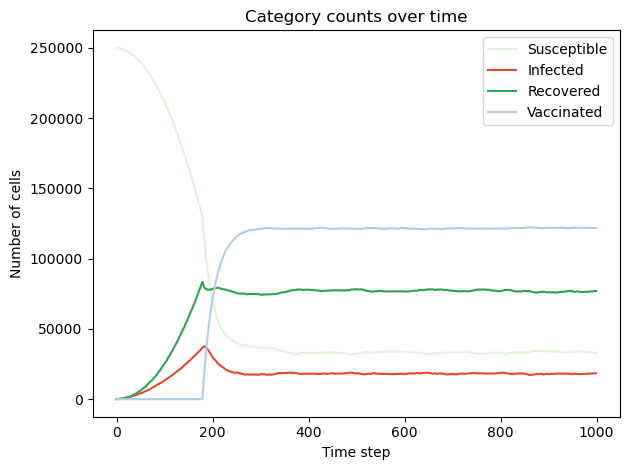

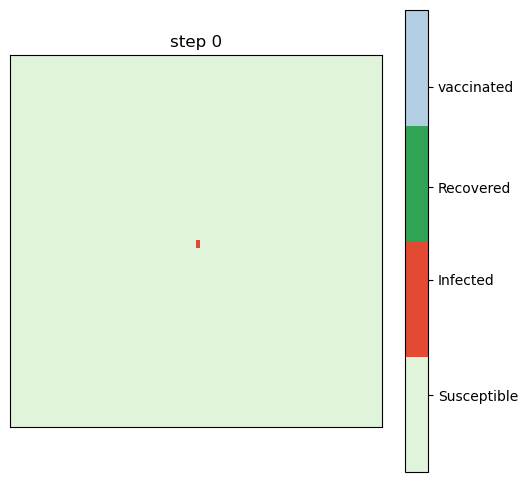

In [6]:
def simulate_sirvb_lattice(initial_grid, steps, *, start_vacc=180, **params):
    """Return array shape (steps, rows, cols).
    Vaccination begins at `start_vacc` (inclusive)."""
    traj, current = [initial_grid.copy()], initial_grid.copy()
    for step in range(1, steps):
        vacc_on = step >= start_vacc
        current = step_sirvb(current, vacc_on=vacc_on, **params)
        traj.append(current.copy())
        print(f'Finished iter {step}')
    return np.array(traj)

# ------------------------------------------------------------
# 2. one lattice update (t -> t+1)
# ------------------------------------------------------------

def step_sirvb(grid, *, beta_s, beta_v, beta_r, gamma, v_rate, b_rate, vacc_on, rng=np.random):
    rows, cols = grid.shape
    new_grid = grid.copy()

        # ---------------- infection phase ---------------------------------
    inf_S, inf_V, inf_R = set(), set(), set()
    infected_idx = np.argwhere(grid == 1)

    for i, j in infected_idx:
        for x, y in neighbors(grid, i, j):
            state = grid[x, y]
            if state == 0 and rng.random() < beta_s:      # S neighbour
                inf_S.add((x, y))
            elif state == 3 and rng.random() < beta_v:    # V neighbour
                inf_V.add((x, y))
            elif state == 2 and rng.random() < beta_r:    # R neighbour
                inf_R.add((x, y))

    for x, y in inf_S | inf_V | inf_R:                   # commit
        new_grid[x, y] = 1

    # ---------------- recovery phase ----------------------------------
    for i, j in infected_idx:
        if rng.random() < gamma:
            new_grid[i, j] = 2     # I -> R

    # ---------------- vaccination phase -------------------------------
    if vacc_on:
        # susceptibles still susceptible after infection phase
        for i, j in np.argwhere(new_grid == 0):
            if rng.random() < v_rate:
                new_grid[i, j] = 3  # S -> V
        # allow recovered to get vaccinated too
        for i, j in np.argwhere(new_grid == 2):
            if rng.random() < v_rate:
                new_grid[i, j] = 3  # R -> V

    # ---------------- immediate loss of immunity ----------------------
    for i, j in np.argwhere(new_grid == 2):
        if grid[i, j] != 2 and rng.random() < b_rate:  # new R only
            new_grid[i, j] = 0
    for i, j in np.argwhere(new_grid == 3):
        if rng.random() < b_rate:  # new V only
            new_grid[i, j] = 0

    return new_grid

rows = cols = 500
grid0 = np.zeros((rows, cols), dtype=int)
grid0[rows//2:rows//2+10, cols//2:cols//2+5] = 1  # single seed infection

sim = simulate_sirvb_lattice(
    grid0, steps=1000,
    beta_s=0.5, beta_v=0.005, beta_r=0.05, gamma=0.25,
    v_rate=0.025, b_rate=0.02
)

# quickly show final state counts
uniq, counts = np.unique(sim[-1], return_counts=True)
print(dict(zip(uniq, counts)))

S_count = (sim == 0).sum(axis=(1,2))
I_count = (sim == 1).sum(axis=(1,2))
R_count = (sim == 2).sum(axis=(1,2))
V_count = (sim == 3).sum(axis=(1,2))


# ------------- plot time series -----------------------
plt.figure()
plt.plot(S_count, label="Susceptible", color = "#e0f3db")
plt.plot(I_count, label="Infected", color ='#e34a33')
plt.plot(R_count, label="Recovered", color = '#31a354')
plt.plot(V_count, label="Vaccinated", color = '#b3cde3')

plt.xlabel("Time step")
plt.ylabel("Number of cells")
plt.title("Category counts over time")
plt.legend()
plt.tight_layout()
plt.show()

ani = animate_lattice(sim, interval=80)
ani.save("sirvb_sim_longer.gif", writer='pillow', fps=12)

Finished iter 1
Finished iter 2
Finished iter 3
Finished iter 4
Finished iter 5
Finished iter 6
Finished iter 7
Finished iter 8
Finished iter 9
Finished iter 10
Finished iter 11
Finished iter 12
Finished iter 13
Finished iter 14
Finished iter 15
Finished iter 16
Finished iter 17
Finished iter 18
Finished iter 19
Finished iter 20
Finished iter 21
Finished iter 22
Finished iter 23
Finished iter 24
Finished iter 25
Finished iter 26
Finished iter 27
Finished iter 28
Finished iter 29
Finished iter 30
Finished iter 31
Finished iter 32
Finished iter 33
Finished iter 34
Finished iter 35
Finished iter 36
Finished iter 37
Finished iter 38
Finished iter 39
Finished iter 40
Finished iter 41
Finished iter 42
Finished iter 43
Finished iter 44
Finished iter 45
Finished iter 46
Finished iter 47
Finished iter 48
Finished iter 49
Finished iter 50
Finished iter 51
Finished iter 52
Finished iter 53
Finished iter 54
Finished iter 55
Finished iter 56
Finished iter 57
Finished iter 58
Finished iter 59
Finish

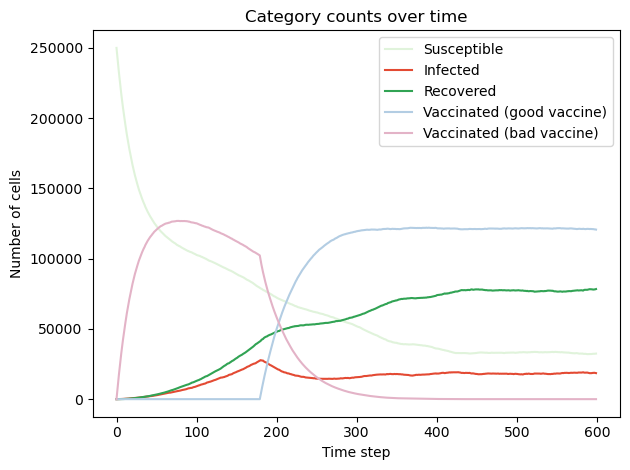

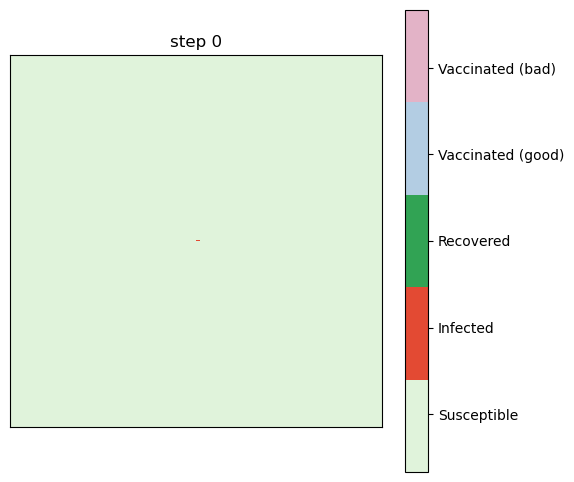

In [21]:
def simulate_sirvb_lattice(initial_grid, steps, *, start_vacc=180, **params):
    """Return array shape (steps, rows, cols).
    Vaccination begins at `start_vacc` (inclusive)."""
    traj, current = [initial_grid.copy()], initial_grid.copy()
    for step in range(1, steps):
        vacc_on = step >= start_vacc
        current = step_sirvb(current, vacc_on=vacc_on, **params)
        traj.append(current.copy())
        print(f'Finished iter {step}')
    return np.array(traj)

# ------------------------------------------------------------
# 2. one lattice update (t -> t+1)
# ------------------------------------------------------------

def step_sirvb(grid, *, beta_s, beta_v1, beta_v2, beta_r, gamma, v_rate, b_rate, vacc_on, rng=np.random):
    rows, cols = grid.shape
    new_grid = grid.copy()

        # ---------------- infection phase ---------------------------------
    inf_S, inf_V1, inf_V2, inf_R = set(), set(), set(), set()
    infected_idx = np.argwhere(grid == 1)

    for i, j in infected_idx:
        for x, y in neighbors(grid, i, j):
            state = grid[x, y]
            if state == 0 and rng.random() < beta_s:      # S neighbour
                inf_S.add((x, y))
            elif state == 3 and rng.random() < beta_v1:    # V neighbour
                inf_V1.add((x, y))
            elif state == 5 and rng.random() < beta_v2:    # V neighbour
                inf_V2.add((x, y))
            elif state == 2 and rng.random() < beta_r:    # R neighbour
                inf_R.add((x, y))

    for x, y in inf_S | inf_V1 | inf_V2 |inf_R:                   # commit
        new_grid[x, y] = 1

    # ---------------- recovery phase ----------------------------------
    for i, j in infected_idx:
        if rng.random() < gamma:
            new_grid[i, j] = 2     # I -> R

    # ---------------- vaccination phase -------------------------------
    if vacc_on:
        # susceptibles still susceptible after infection phase
        for i, j in np.argwhere(new_grid == 0):
            if rng.random() < v_rate:
                new_grid[i, j] = 3  # S -> V
        # allow recovered to get vaccinated too
        for i, j in np.argwhere(new_grid == 2):
            if rng.random() < v_rate:
                new_grid[i, j] = 3  # R -> V
    else:
        for i, j in np.argwhere(new_grid == 0):
            if rng.random() < v_rate:
                new_grid[i, j] = 5  # S -> V
        # allow recovered to get vaccinated too
        for i, j in np.argwhere(new_grid == 2):
            if rng.random() < v_rate:
                new_grid[i, j] = 5  # R -> V


    # ---------------- immediate loss of immunity ----------------------
    for i, j in np.argwhere(new_grid == 2):
        if grid[i, j] != 2 and rng.random() < b_rate:  # new R only
            new_grid[i, j] = 0
    for i, j in np.argwhere(new_grid == 3):
        if rng.random() < b_rate:  # new V only
            new_grid[i, j] = 0
    for i, j in np.argwhere(new_grid == 5):
        if rng.random() < b_rate:  # new V only
            new_grid[i, j] = 0

    return new_grid

rows = cols = 500
grid0 = np.zeros((rows, cols), dtype=int)
grid0[rows//2:rows//2+1, cols//2:cols//2+5] = 1  # single seed infection

sim = simulate_sirvb_lattice(
    grid0, steps=600,
    beta_s=0.5, beta_v1=0.005, beta_v2=0.1, beta_r=0.05, gamma=0.25,
    v_rate=0.025, b_rate=0.02
)

# quickly show final state counts
uniq, counts = np.unique(sim[-1], return_counts=True)
print(dict(zip(uniq, counts)))

S_count = (sim == 0).sum(axis=(1,2))
I_count = (sim == 1).sum(axis=(1,2))
R_count = (sim == 2).sum(axis=(1,2))
V1_count = (sim == 3).sum(axis=(1,2))
V2_count = (sim == 5).sum(axis=(1,2))



def animate_lattice(traj, interval=150):
    cmap = ListedColormap(["#e0f3db", "#e34a33", "#31a354", "#b3cde3", "#e3b3c7"])
    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(traj[0],
               cmap=cmap,
               vmin=0, vmax=4,
               interpolation='nearest',   # <- no smoothing
               aspect='equal') 
    ax.set_xticks([]); ax.set_yticks([])

    def update(frame):
        im.set_data(traj[frame])
        ax.set_title(f"step {frame}")
        return im,
    cbar = plt.colorbar(im, ticks=[0.5, 1.25, 2, 2.75, 3.5])
    cbar.ax.set_yticklabels(['Susceptible', 'Infected', 'Recovered', 'Vaccinated (good)', 'Vaccinated (bad)'])

    ani = FuncAnimation(fig, update, frames=len(traj), interval=interval, blit=True)
    plt.show()
    return ani

# ------------- plot time series -----------------------
plt.figure()
plt.plot(S_count, label="Susceptible", color = "#e0f3db")
plt.plot(I_count, label="Infected", color ='#e34a33')
plt.plot(R_count, label="Recovered", color = '#31a354')
plt.plot(V1_count, label="Vaccinated (good vaccine)", color = '#b3cde3')
plt.plot(V2_count, label="Vaccinated (bad vaccine)", color = "#e3b3c7")


plt.xlabel("Time step")
plt.ylabel("Number of cells")
plt.title("Category counts over time")
plt.legend()
plt.tight_layout()
plt.show()

ani = animate_lattice(sim, interval=80)
ani.save("sirvb_sim_delayed_2vacc_good.gif", writer='pillow', fps=12)

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 5],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 5, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 5],
        ...,
        [0, 0, 5, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 5, 0],
        [0, 0, 5, ..., 0, 5, 0]],

       ...,

       [[1, 1, 1, ..., 2, 2, 2],
        [2, 1, 0, ..., 1, 1, 1],
        [1, 1, 2, ..., 2, 1, 1],
        ...,
        [2, 1, 2, ..., 2, 1, 2],
        [1, 2, 5, ..., 1, 2, 1],
        [2, 1, 1, ..., 1, 2, 2]],

       [[1, 2, 1, ..., 2, 2, 2],
        [1, 2, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 2, 1, 1],
        ...,
        [2, 1, 2, ..., 